# Stability diagram

In [3]:
%reset -f
import numpy as np

import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
import pickle as pkl
import multiprocessing as mp

%matplotlib notebook




In [4]:

# Set style of plots
colwidth=3.5
figwidth=6
figheight=4.5
ticksize= 8 *figwidth/colwidth 
labelsize=10 *figwidth/colwidth
titlesize = 10 *figwidth/colwidth
annotatesize= ticksize*1
# mpl.style.use('classic')
mpl.rcParams.update({'font.size':ticksize }) 
mpl.rcParams.update({'legend.fontsize':ticksize })# legend
mpl.rcParams.update({'ytick.labelsize':ticksize})
mpl.rcParams.update({'xtick.labelsize':ticksize})
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'axes.labelsize':labelsize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize' :titlesize})
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-3,3]})
mpl.rcParams.update({'figure.figsize':[6,5]})
mpl.rcParams.update({'image.cmap':'rainbow'})
mpl.rcParams.update({'axes.formatter.useoffset':True})   # no offset of axis
mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4 

# mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

# To get sans-serif
mpl.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'})

# To use unicode
# params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# params = {'text.usetex': True , 'mathtext.fontset': 'stixsans'}
# plt.rcParams.update(params)

# To be able to use SI units as micro (automatically upright)
plt.rc('text', usetex = True)
params = {'text.latex.preamble': [r'\usepackage{siunitx}', r'\usepackage{cmbright}']}
plt.rcParams.update(params)


# Functions

In [5]:
def distributions(Qs,dist_nr=1):
    Qa = Qs[0]
    Qz = Qs[-1]
    nQ = np.size(Qs)
    
    dist = np.zeros(nQ)
    
    if dist_nr==1:
        sigma = (Qz-Qa)/12
        mQ = Qa+(Qz-Qa)*.5
        dist = np.exp(-(Qs-mQ)**2/(2*sigma**2))
        
    elif dist_nr==2:
        sigma = (Qz-Qa)/12
        Q0 = Qa+(Qz-Qa)*.2
        dist[Qs>=Q0] = ((Qs-Q0)/sigma*np.exp(-(Qs-Q0)/sigma))[Qs>=Q0]
        
    elif dist_nr==3:
        sigma = (Qz-Qa)/12
        mQ = Qa+(Qz-Qa)*.5
        dist = np.exp(-(Qs-mQ)**4/(2*sigma**4))
        
    A = np.trapz(dist,Qs)
    dist = dist/A
    distf = sc.interpolate.interp1d(Qs,dist,kind='quadratic',bounds_error=False,fill_value=0)
    return distf

# Example

<IPython.core.display.Javascript object>


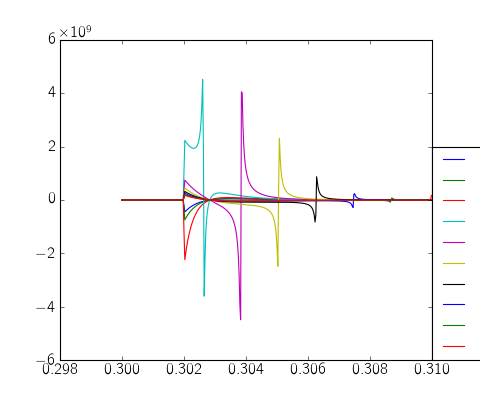

/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [8]:
Qs = np.linspace(0.30,0.31,2000)
distf = distributions(Qs,2)
Qs = Qs[::5]
dQ = np.diff(Qs[:2])*1
epsilon=2e-5
bool_plotintegrand=1

def integrand(Q):
    return (distf(Qs+dQ) - distf(Qs-dQ))/(2*dQ) / (Q-Qs+1j*epsilon)

Qwidth = Qs[-1]-Qs[0]
Qfree = np.linspace(Qs[0]-.1*Qwidth,Qs[-1]+.1*Qwidth,100)
Qsmid = np.linspace(Qs[0]+.1*Qwidth,Qs[-1]-.1*Qwidth,100)
BTFs = np.zeros_like(Qfree,dtype=complex)


if bool_plotintegrand:
    plt.figure()
for iQ,Q in enumerate(Qfree):
    BTFs[iQ] = np.trapz(integrand(Q),Qs)
    if bool_plotintegrand and iQ%10==0:
        plt.plot(Qs,integrand(Q),label=Q)
if bool_plotintegrand:
    lgd = plt.legend(loc=(1,0))
#     plt.tight_layout()

<IPython.core.display.Javascript object>


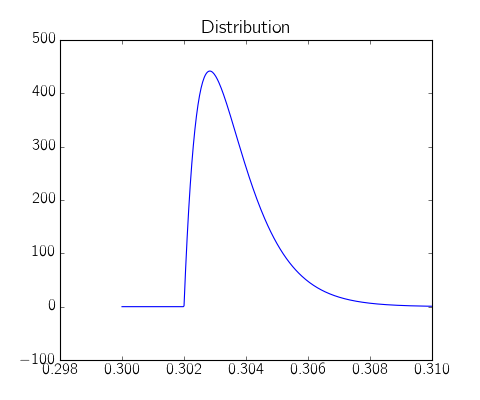

<IPython.core.display.Javascript object>


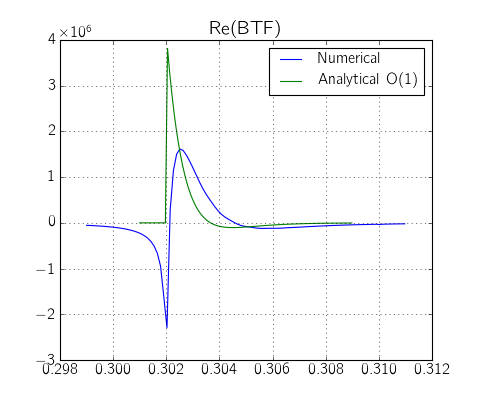

<IPython.core.display.Javascript object>


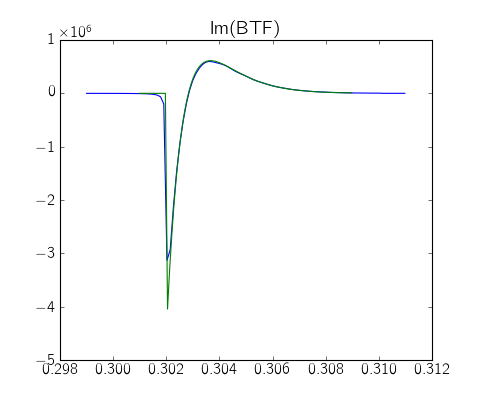

<IPython.core.display.Javascript object>


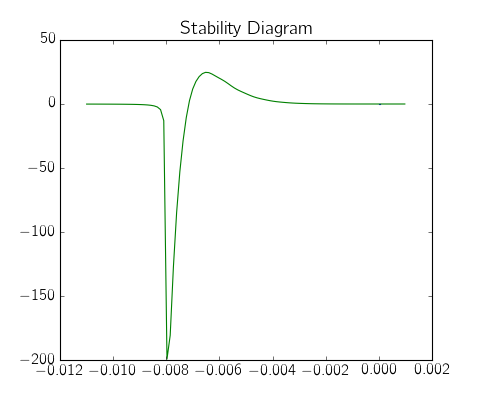

<IPython.core.display.Javascript object>


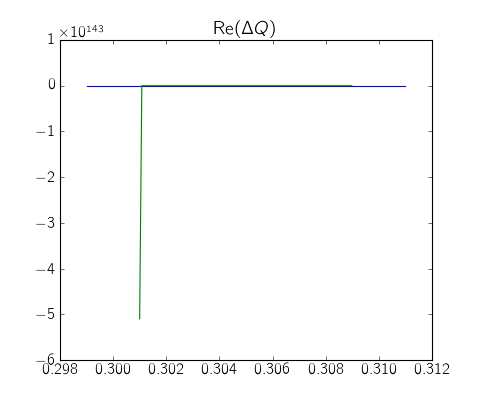

<IPython.core.display.Javascript object>


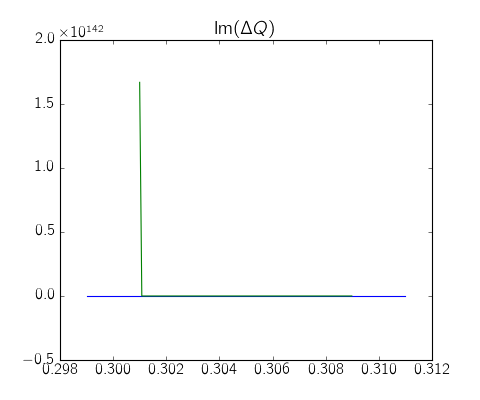

In [14]:
plt.figure()
plt.title('Distribution')
plt.plot(Qs,distf(Qs))



plt.figure()
plt.title('Re(BTF)')
plt.grid(True)
plt.plot(Qfree,BTFs.real,label='Numerical')
C = .0006
distf2 = (distf(Qsmid+dQ)  -2*distf(Qsmid)   +distf(Qsmid-dQ))/dQ**2
distf4 = (distf(Qsmid+2*dQ)-4*distf(Qsmid+dQ)+6*distf(Qsmid)-4*distf(Qsmid-dQ)+distf(Qsmid-2*dQ))/dQ**4
BTFreal_fo = -(distf(Qsmid+dQ)-2*distf(Qsmid)+distf(Qsmid-dQ))/dQ**2  * 2*C
plt.plot(Qsmid,BTFreal_fo,label='Analytical O(1)')
# BTFreal_fo = -distf2 *2*C - distf4 * C**3
# plt.plot(Qsmid,BTFreal_fo,label='Analytical O(3)')
plt.legend(loc=0)

plt.figure()
plt.title('Im(BTF)')
plt.plot(Qfree,BTFs.imag)
BTFimag_fo = -np.pi*(distf(Qsmid+dQ)-distf(Qsmid-dQ))/(dQ*2)
plt.plot(Qsmid,BTFimag_fo )



plt.figure()
plt.title('Stability Diagram')
Qr = -BTFs.real/np.abs(BTFs)**2
tau=  BTFs.imag/np.abs(BTFs)**2
plt.plot(Qr,tau)

Qr_fo = - BTFreal_fo / (BTFreal_fo**2+BTFimag_fo**2)
tau_fo=   BTFimag_fo / (BTFreal_fo**2+BTFimag_fo**2)
# plt.plot(Qr_fo,tau_fo,'<--')

dQfree = Qfree-0.31
tau2 = BTFs.imag * (dQfree)**2
plt.plot(dQfree,tau2)

plt.figure()
plt.title(r'Re($\Delta Q$)')
plt.plot(Qfree,Qr)
plt.plot(Qsmid,Qr_fo)

plt.figure()
plt.title(r'Im($\Delta Q$)')
plt.plot(Qfree,tau)
plt.plot(Qsmid,tau_fo)

<IPython.core.display.Javascript object>


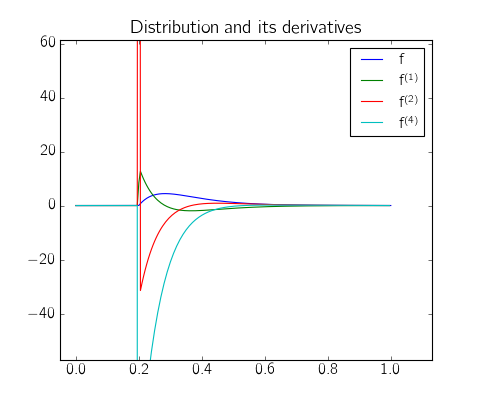

(-5, 5)

In [220]:
Qs = np.linspace(0.0,1,1000)
distf = distributions(Qs,2)
dQ = Qs[1]-Qs[0]
Qf = Qs[::5]

C = 0.1
distf1 = (distf(Qf+dQ)-distf(Qf-dQ))/dQ*.5 * C
distf2 = (distf(Qf+dQ)-2*distf(Qf)+distf(Qf-dQ))/dQ**2 *C**2
distf3 = (distf(Qf+2*dQ)-2*distf(Qf+dQ)+2*distf(Qf-dQ)-distf(Qf-2*dQ))/dQ**3/2 *C**3
distf4 = (distf(Qf+2*dQ)-4*distf(Qf+dQ)+6*distf(Qf)-4*distf(Qf-dQ)+distf(Qf-2*dQ))/dQ**4 *C**4

plt.figure()
plt.title('Distribution and its derivatives')
plt.plot(Qs,distf(Qs),label='f')
plt.plot(Qf,distf1,label='f^{(1)}')
plt.plot(Qf,distf2,label='f^{(2)}')
# plt.plot(Qf,distf3,label='f^{(3)}')
plt.plot(Qf,distf4,label='f^{(4)}')
plt.legend(loc=0)
plt.ylim(-5,5)